In this file, we are going to train the model with N grams.

In [15]:
import pickle as pkl

# regenerate the lists of label according to the file
train_label = [0] * 10000 + [1] * 10000
val_label = [0] * 2500 + [1] * 2500
test_label = [0] * 12500 + [1] * 12500

# load preprocessed train, val and test datasets. First use 2-gram as default
train_data_tokens = pkl.load(open("train_data_tokens_2g.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_2g.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens_2g.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_2g.p", "rb"))

# check the length of the dataset
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 9497702


In [2]:
# create the vocabulary of most common tokens in the training set
from collections import Counter

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


In [3]:
# create PyTorch DataLoader

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


In [75]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfNGrams(nn.Module):
    """
    BagOfNGrams classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfNGrams, self).__init__()

        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out


In [5]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


# Parameter tuning

### test for the best embedding size

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

max_vocab_size = 20000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

print("Building the vocabulary")
token2id, id2token = build_vocab(all_train_tokens)

print("Transfering the tokens into indices")
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

MAX_SENTENCE_LENGTH = 200

val_acc_no = []
train_acc_no = []

print("Loading the data by DataLoader")
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

learning_rate = 0.001
num_epochs = 5

criterion = torch.nn.CrossEntropyLoss()  

for emd_dim in [100, 200, 500, 750, 1000]:
    
    val_acc = []
    
    print("Building the Bag of N grams Model")
    model = BagOfNGrams(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print("Training ... ")
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                val_acc.append(test_model(val_loader, model))
                
    plt.plot(val_acc, label = 'Val acc for emb_dim = {}'.format(emd_dim))

plt.legend(loc='upper left')
plt.show()
                

### test for the best learning rate

Building the vocabulary
Transfering the tokens into indices
Loading the data by DataLoader
Building the Bag of N grams Model
Training ... 
The highest val acc is 87.16
Building the Bag of N grams Model
Training ... 
The highest val acc is 87.36
Building the Bag of N grams Model
Training ... 
The highest val acc is 87.0
Building the Bag of N grams Model
Training ... 
The highest val acc is 86.84
Building the Bag of N grams Model
Training ... 
The highest val acc is 86.58


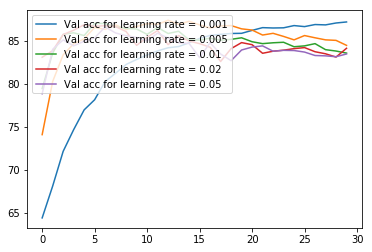

In [107]:
max_vocab_size = 20000

print("Building the vocabulary")
token2id, id2token = build_vocab(all_train_tokens)

print("Transfering the tokens into indices")
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print("Loading the data by DataLoader")
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

emd_dim = 100
num_epochs = 5

for learning_rate in [0.001, 0.005, 0.01, 0.02, 0.05]:
    
    val_acc = []
    
    print("Building the Bag of N grams Model")
    model = BagOfNGrams(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print("Training ... ")
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc.append(test_model(val_loader, model))
    plt.plot(val_acc, label = 'Val acc for learning rate = {}'.format(learning_rate))
    print("The highest val acc is {}".format(max(val_acc)))
    
plt.legend(loc='upper left')
plt.show()
                

### test for the best vocabulary size

Building the vocabulary with size 10000
Transfering the tokens into indices
Loading the data by DataLoader
Training ... 
Building the vocabulary with size 20000
Transfering the tokens into indices
Loading the data by DataLoader
Training ... 
Building the vocabulary with size 50000
Transfering the tokens into indices
Loading the data by DataLoader
Training ... 
Building the vocabulary with size 100000
Transfering the tokens into indices
Loading the data by DataLoader
Training ... 
Building the vocabulary with size 200000
Transfering the tokens into indices
Loading the data by DataLoader
Training ... 


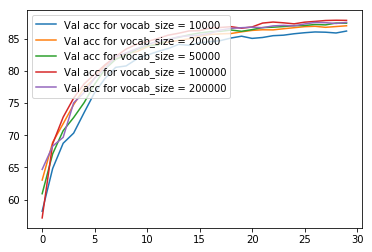

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

learning_rate = 0.001

for max_vocab_size in [10000, 20000, 50000, 100000, 200000]:
    
    val_acc = []
   
    print("Building the vocabulary with size {}".format(max_vocab_size))
    token2id, id2token = build_vocab(all_train_tokens)

    print("Transfering the tokens into indices")
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)
    
    print("Loading the data by DataLoader")
    train_dataset = NewsGroupDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)
    val_dataset = NewsGroupDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)
    test_dataset = NewsGroupDataset(test_data_indices, test_label)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    
    model = BagOfNGrams(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print("Training ... ")
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc.append(test_model(val_loader, model))
    plt.plot(val_acc, label = 'Val acc for vocab_size = {}'.format(max_vocab_size))

plt.legend(loc='upper left')
plt.show()
                

### Test for linear annealing learning rate

In [76]:
# First get the training curve without linear annealing
max_vocab_size = 100000

print("Building the vocabulary")
token2id, id2token = build_vocab(all_train_tokens)

print("Transfering the tokens into indices")
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print("Loading the data by DataLoader")
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

print("Building the Bag of N grams Model")
model = BagOfNGrams(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

list_val_acc = []
list_train_acc = []

print("Training ... ")
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            list_val_acc.append(test_model(val_loader, model))
            list_train_acc.append(test_model(train_loader, model))
            

Building the vocabulary
Transfering the tokens into indices
Loading the data by DataLoader
Building the Bag of N grams Model
Training ... 


In [78]:
# Then get the training curve with linear annealing
list_val_acc_lambdaLR = []
list_train_acc_lambdaLR = []

model = BagOfNGrams(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: num_epochs - epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

print("Training ... ")
for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
            list_val_acc_lambdaLR.append(test_model(val_loader, model))
            list_train_acc_lambdaLR.append(test_model(train_loader, model))
            

Training ... 


In [86]:
# Then get the training curve with linear annealing
list_val_acc_lambdaLR = []
list_train_acc_lambdaLR = []

model = BagOfNGrams(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: num_epochs - epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

print("Training ... ")
for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            list_val_acc_lambdaLR.append(test_model(val_loader, model))
            list_train_acc_lambdaLR.append(test_model(train_loader, model))
            

Training ... 


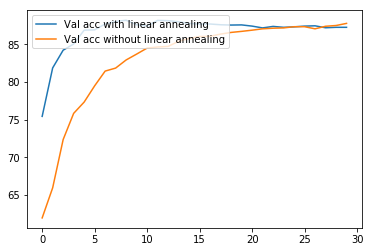

In [87]:
# compare the val acc of the two results
%matplotlib inline
plt.plot(list_val_acc_lambdaLR, label = 'Val acc with linear annealing')
plt.plot(list_val_acc, label = 'Val acc without linear annealing')

plt.legend(loc='upper left')
plt.show()

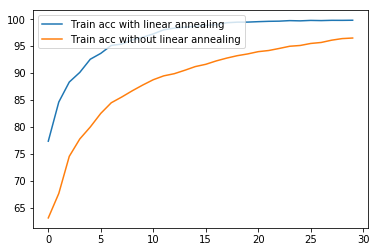

In [88]:
# compare the train acc of the two results
%matplotlib inline
plt.plot(list_train_acc_lambdaLR, label = 'Train acc with linear annealing')
plt.plot(list_train_acc, label = 'Train acc without linear annealing')

plt.legend(loc='upper left')
plt.show()

### Test for differnt optimizers

In [96]:
# Get the training curve with SGD optimizer
list_val_acc_SGD = []
list_train_acc_SGD = []

model = BagOfNGrams(len(id2token), emb_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print("Training ... ")
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))            
            list_val_acc_SGD.append(val_acc)
            list_train_acc_SGD.append(train_acc)
            

Training ... 
Epoch: [1/5], Step: [101/625], Validation Acc: 50.62, Train acc: 50.43
Epoch: [1/5], Step: [201/625], Validation Acc: 50.76, Train acc: 50.39
Epoch: [1/5], Step: [301/625], Validation Acc: 50.7, Train acc: 50.405
Epoch: [1/5], Step: [401/625], Validation Acc: 50.76, Train acc: 50.555
Epoch: [1/5], Step: [501/625], Validation Acc: 50.38, Train acc: 50.645
Epoch: [1/5], Step: [601/625], Validation Acc: 50.38, Train acc: 50.845
Epoch: [2/5], Step: [101/625], Validation Acc: 50.22, Train acc: 51.075
Epoch: [2/5], Step: [201/625], Validation Acc: 50.66, Train acc: 51.17
Epoch: [2/5], Step: [301/625], Validation Acc: 51.06, Train acc: 51.28
Epoch: [2/5], Step: [401/625], Validation Acc: 51.22, Train acc: 51.385
Epoch: [2/5], Step: [501/625], Validation Acc: 51.66, Train acc: 51.57
Epoch: [2/5], Step: [601/625], Validation Acc: 51.78, Train acc: 51.745
Epoch: [3/5], Step: [101/625], Validation Acc: 51.76, Train acc: 51.94
Epoch: [3/5], Step: [201/625], Validation Acc: 52.0, Trai

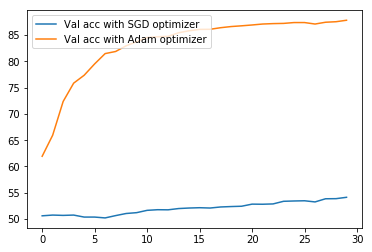

In [97]:
# compare the val acc of the two results
%matplotlib inline
plt.plot(list_val_acc_SGD, label = 'Val acc with SGD optimizer')
plt.plot(list_val_acc, label = 'Val acc with Adam optimizer')

plt.legend(loc='upper left')
plt.show()

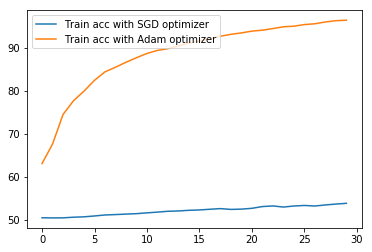

In [98]:
# compare the train acc of the two results
%matplotlib inline
plt.plot(list_train_acc_SGD, label = 'Train acc with SGD optimizer')
plt.plot(list_train_acc, label = 'Train acc with Adam optimizer')

plt.legend(loc='upper left')
plt.show()

In [99]:
# Get the training curve with SGD optimizer
list_val_acc_SGD_2 = []
list_train_acc_SGD_2 = []

model = BagOfNGrams(len(id2token), emb_dim)
learning_rate = 0.01
num_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print("Training ... ")
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))            
            list_val_acc_SGD_2.append(val_acc)
            list_train_acc_SGD_2.append(train_acc)
            

Training ... 
Epoch: [1/10], Step: [101/625], Validation Acc: 50.76, Train acc: 51.345
Epoch: [1/10], Step: [201/625], Validation Acc: 51.82, Train acc: 52.605
Epoch: [1/10], Step: [301/625], Validation Acc: 53.08, Train acc: 53.555
Epoch: [1/10], Step: [401/625], Validation Acc: 54.06, Train acc: 54.71
Epoch: [1/10], Step: [501/625], Validation Acc: 55.16, Train acc: 55.81
Epoch: [1/10], Step: [601/625], Validation Acc: 55.52, Train acc: 56.7
Epoch: [2/10], Step: [101/625], Validation Acc: 56.58, Train acc: 57.705
Epoch: [2/10], Step: [201/625], Validation Acc: 56.86, Train acc: 58.32
Epoch: [2/10], Step: [301/625], Validation Acc: 57.86, Train acc: 58.4
Epoch: [2/10], Step: [401/625], Validation Acc: 57.44, Train acc: 58.025
Epoch: [2/10], Step: [501/625], Validation Acc: 58.24, Train acc: 59.01
Epoch: [2/10], Step: [601/625], Validation Acc: 58.3, Train acc: 59.765
Epoch: [3/10], Step: [101/625], Validation Acc: 59.1, Train acc: 59.445
Epoch: [3/10], Step: [201/625], Validation Acc:

In [100]:
# Get the training curve with SGD optimizer
list_val_acc_SGD_3 = []
list_train_acc_SGD_3 = []

model = BagOfNGrams(len(id2token), emb_dim)
learning_rate = 0.5
num_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print("Training ... ")
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))            
            list_val_acc_SGD_3.append(val_acc)
            list_train_acc_SGD_3.append(train_acc)
            

Training ... 
Epoch: [1/10], Step: [101/625], Validation Acc: 59.96, Train acc: 59.915
Epoch: [1/10], Step: [201/625], Validation Acc: 62.92, Train acc: 62.505
Epoch: [1/10], Step: [301/625], Validation Acc: 63.68, Train acc: 63.6
Epoch: [1/10], Step: [401/625], Validation Acc: 58.24, Train acc: 58.935
Epoch: [1/10], Step: [501/625], Validation Acc: 66.04, Train acc: 66.005
Epoch: [1/10], Step: [601/625], Validation Acc: 64.48, Train acc: 64.79
Epoch: [2/10], Step: [101/625], Validation Acc: 62.1, Train acc: 62.03
Epoch: [2/10], Step: [201/625], Validation Acc: 67.14, Train acc: 67.655
Epoch: [2/10], Step: [301/625], Validation Acc: 63.16, Train acc: 64.14
Epoch: [2/10], Step: [401/625], Validation Acc: 66.52, Train acc: 66.46
Epoch: [2/10], Step: [501/625], Validation Acc: 68.22, Train acc: 68.3
Epoch: [2/10], Step: [601/625], Validation Acc: 68.22, Train acc: 68.525
Epoch: [3/10], Step: [101/625], Validation Acc: 68.78, Train acc: 69.51
Epoch: [3/10], Step: [201/625], Validation Acc:

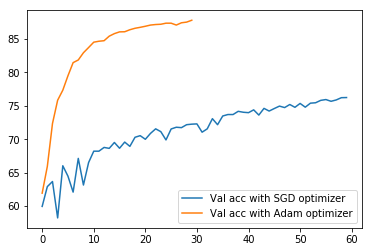

In [105]:
# compare the val acc of the two results
%matplotlib inline
plt.plot(list_val_acc_SGD_3, label = 'Val acc with SGD optimizer')
plt.plot(list_val_acc, label = 'Val acc with Adam optimizer')

plt.legend(loc='lower right')
plt.show()

### Test for N in N-grams

In [109]:
# load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_nohtml.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_nohtml.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens_nohtml.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_nohtml.p", "rb"))

max_vocab_size = 100000

print("Building the vocabulary")
token2id, id2token = build_vocab(all_train_tokens)

print("Transfering the tokens into indices")
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print("Loading the data by DataLoader")
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

emd_dim = 100
num_epochs = 5
learning_rate = 0.001

print("Building the Bag of N grams Model")
model = BagOfNGrams(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

list_val_acc_1g = []
list_train_acc_1g = []

print("Training ... ")
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))            
            list_val_acc_1g.append(val_acc)
            list_train_acc_1g.append(train_acc)


Building the vocabulary
Transfering the tokens into indices
Loading the data by DataLoader
Building the Bag of N grams Model
Training ... 
Epoch: [1/5], Step: [101/625], Validation Acc: 64.16, Train acc: 63.225
Epoch: [1/5], Step: [201/625], Validation Acc: 68.8, Train acc: 68.415
Epoch: [1/5], Step: [301/625], Validation Acc: 71.92, Train acc: 72.705
Epoch: [1/5], Step: [401/625], Validation Acc: 74.62, Train acc: 75.905
Epoch: [1/5], Step: [501/625], Validation Acc: 77.62, Train acc: 79.4
Epoch: [1/5], Step: [601/625], Validation Acc: 79.24, Train acc: 81.815
Epoch: [2/5], Step: [101/625], Validation Acc: 80.98, Train acc: 83.885
Epoch: [2/5], Step: [201/625], Validation Acc: 81.84, Train acc: 85.16
Epoch: [2/5], Step: [301/625], Validation Acc: 82.82, Train acc: 86.29
Epoch: [2/5], Step: [401/625], Validation Acc: 83.46, Train acc: 87.18
Epoch: [2/5], Step: [501/625], Validation Acc: 84.04, Train acc: 87.975
Epoch: [2/5], Step: [601/625], Validation Acc: 84.76, Train acc: 88.765
Epo

In [110]:
# load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_3g.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_3g.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_3g.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_3g.p", "rb"))

print("Building the vocabulary")
token2id, id2token = build_vocab(all_train_tokens)

print("Transfering the tokens into indices")
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print("Loading the data by DataLoader")
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

print("Building the Bag of N grams Model")
model = BagOfNGrams(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

list_val_acc_3g = []
list_train_acc_3g = []

print("Training ... ")
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
            list_val_acc_3g.append(val_acc)
            list_train_acc_3g.append(train_acc)



Building the vocabulary
Transfering the tokens into indices
Loading the data by DataLoader
Building the Bag of N grams Model
Training ... 
Epoch: [1/5], Step: [101/625], Validation Acc: 56.74, Train acc: 56.885
Epoch: [1/5], Step: [201/625], Validation Acc: 67.42, Train acc: 68.855
Epoch: [1/5], Step: [301/625], Validation Acc: 70.86, Train acc: 72.025
Epoch: [1/5], Step: [401/625], Validation Acc: 73.6, Train acc: 75.26
Epoch: [1/5], Step: [501/625], Validation Acc: 75.94, Train acc: 78.79
Epoch: [1/5], Step: [601/625], Validation Acc: 78.2, Train acc: 81.135
Epoch: [2/5], Step: [101/625], Validation Acc: 80.28, Train acc: 83.06
Epoch: [2/5], Step: [201/625], Validation Acc: 81.74, Train acc: 84.73
Epoch: [2/5], Step: [301/625], Validation Acc: 82.32, Train acc: 85.99
Epoch: [2/5], Step: [401/625], Validation Acc: 83.2, Train acc: 87.02
Epoch: [2/5], Step: [501/625], Validation Acc: 83.3, Train acc: 87.755
Epoch: [2/5], Step: [601/625], Validation Acc: 84.18, Train acc: 88.655
Epoch: 

In [115]:
# load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_4g.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_4g.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_4g.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_4g.p", "rb"))

print("Building the vocabulary")
token2id, id2token = build_vocab(all_train_tokens)

print("Transfering the tokens into indices")
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print("Loading the data by DataLoader")
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

print("Building the Bag of N grams Model")
model = BagOfNGrams(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

list_val_acc_4g = []
list_train_acc_4g = []

print("Training ... ")
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
            list_val_acc_4g.append(val_acc)
            list_train_acc_4g.append(train_acc)



Building the vocabulary
Transfering the tokens into indices
Loading the data by DataLoader
Building the Bag of N grams Model
Training ... 
Epoch: [1/5], Step: [101/625], Validation Acc: 58.88, Train acc: 59.395
Epoch: [1/5], Step: [201/625], Validation Acc: 65.5, Train acc: 66.8
Epoch: [1/5], Step: [301/625], Validation Acc: 71.3, Train acc: 72.89
Epoch: [1/5], Step: [401/625], Validation Acc: 73.58, Train acc: 75.575
Epoch: [1/5], Step: [501/625], Validation Acc: 76.78, Train acc: 78.83
Epoch: [1/5], Step: [601/625], Validation Acc: 78.88, Train acc: 81.65
Epoch: [2/5], Step: [101/625], Validation Acc: 80.9, Train acc: 83.79
Epoch: [2/5], Step: [201/625], Validation Acc: 81.96, Train acc: 85.25
Epoch: [2/5], Step: [301/625], Validation Acc: 82.78, Train acc: 86.085
Epoch: [2/5], Step: [401/625], Validation Acc: 83.4, Train acc: 87.305
Epoch: [2/5], Step: [501/625], Validation Acc: 83.56, Train acc: 87.85
Epoch: [2/5], Step: [601/625], Validation Acc: 84.38, Train acc: 88.69
Epoch: [3/

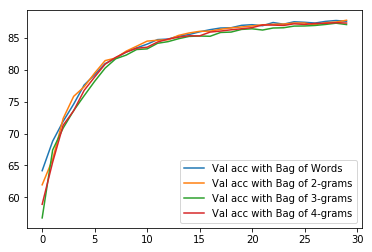

In [116]:
# compare the val acc of the four results
%matplotlib inline
plt.plot(list_val_acc_1g, label = 'Val acc with Bag of Words')
plt.plot(list_val_acc, label = 'Val acc with Bag of 2-grams')
plt.plot(list_val_acc_3g, label = 'Val acc with Bag of 3-grams')
plt.plot(list_val_acc_4g, label = 'Val acc with Bag of 4-grams')

plt.legend(loc='lower right')
plt.show()

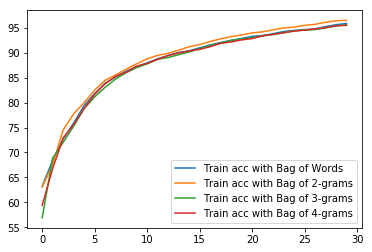

In [117]:
# compare the val acc of the four results
%matplotlib inline
plt.plot(list_train_acc_1g, label = 'Train acc with Bag of Words')
plt.plot(list_train_acc, label = 'Train acc with Bag of 2-grams')
plt.plot(list_train_acc_3g, label = 'Train acc with Bag of 3-grams')
plt.plot(list_train_acc_4g, label = 'Train acc with Bag of 4-grams')

plt.legend(loc='lower right')
plt.show()

### Test for different Tokenization Scheme

In [118]:
# load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

print("Building the vocabulary")
token2id, id2token = build_vocab(all_train_tokens)

print("Transfering the tokens into indices")
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print("Loading the data by DataLoader")
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

print("Building the Bag of N grams Model")
model = BagOfNGrams(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

list_val_acc_html = []
list_train_acc_html = []

print("Training ... ")
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
            list_val_acc_html.append(val_acc)
            list_train_acc_html.append(train_acc)


Building the vocabulary
Transfering the tokens into indices
Loading the data by DataLoader
Building the Bag of N grams Model
Training ... 
Epoch: [1/5], Step: [101/625], Validation Acc: 60.48, Train acc: 60.03
Epoch: [1/5], Step: [201/625], Validation Acc: 68.38, Train acc: 68.82
Epoch: [1/5], Step: [301/625], Validation Acc: 71.26, Train acc: 72.12
Epoch: [1/5], Step: [401/625], Validation Acc: 73.84, Train acc: 76.175
Epoch: [1/5], Step: [501/625], Validation Acc: 76.92, Train acc: 79.47
Epoch: [1/5], Step: [601/625], Validation Acc: 79.44, Train acc: 81.965
Epoch: [2/5], Step: [101/625], Validation Acc: 81.06, Train acc: 84.015
Epoch: [2/5], Step: [201/625], Validation Acc: 82.64, Train acc: 85.38
Epoch: [2/5], Step: [301/625], Validation Acc: 83.16, Train acc: 86.315
Epoch: [2/5], Step: [401/625], Validation Acc: 83.6, Train acc: 87.17
Epoch: [2/5], Step: [501/625], Validation Acc: 83.88, Train acc: 88.135
Epoch: [2/5], Step: [601/625], Validation Acc: 84.6, Train acc: 88.755
Epoch

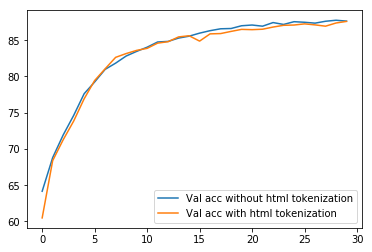

In [119]:
# compare the val acc of the four results
%matplotlib inline
plt.plot(list_val_acc_1g, label = 'Val acc without html tokenization')
plt.plot(list_val_acc_html, label = 'Val acc with html tokenization')

plt.legend(loc='lower right')
plt.show()

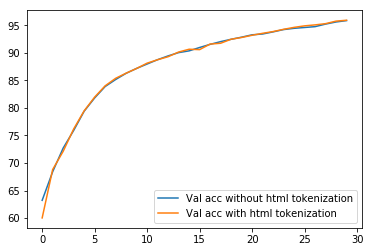

In [120]:
# compare the val acc of the four results
%matplotlib inline
plt.plot(list_train_acc_1g, label = 'Val acc without html tokenization')
plt.plot(list_train_acc_html, label = 'Val acc with html tokenization')

plt.legend(loc='lower right')
plt.show()

## Run with the best configurations and get the result

In [126]:
# load preprocessed train, val and test datasets. First use 2-gram as default
train_data_tokens = pkl.load(open("train_data_tokens_2g.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_2g.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens_2g.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_2g.p", "rb"))

max_vocab_size = 100000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

print("Building the vocabulary")
token2id, id2token = build_vocab(all_train_tokens)

print("Transfering the tokens into indices")
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

MAX_SENTENCE_LENGTH = 200

print("Loading the data by DataLoader")
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

print("Building the Bag of N grams Model")
emb_dim = 100
model = BagOfNGrams(len(id2token), emb_dim)

learning_rate = 0.001
num_epochs = 5 # number epoch to train

criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Training ... ")
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))



Building the vocabulary
Transfering the tokens into indices
Loading the data by DataLoader
Building the Bag of N grams Model
Training ... 
Epoch: [1/5], Step: [101/625], Validation Acc: 54.94, Train Acc: 55.975
Epoch: [1/5], Step: [201/625], Validation Acc: 66.96, Train Acc: 68.94
Epoch: [1/5], Step: [301/625], Validation Acc: 70.64, Train Acc: 72.67
Epoch: [1/5], Step: [401/625], Validation Acc: 73.2, Train Acc: 75.675
Epoch: [1/5], Step: [501/625], Validation Acc: 76.16, Train Acc: 78.95
Epoch: [1/5], Step: [601/625], Validation Acc: 79.08, Train Acc: 81.945
Epoch: [2/5], Step: [101/625], Validation Acc: 80.9, Train Acc: 83.775
Epoch: [2/5], Step: [201/625], Validation Acc: 81.96, Train Acc: 85.61
Epoch: [2/5], Step: [301/625], Validation Acc: 82.84, Train Acc: 87.01
Epoch: [2/5], Step: [401/625], Validation Acc: 83.54, Train Acc: 87.735
Epoch: [2/5], Step: [501/625], Validation Acc: 84.14, Train Acc: 88.585
Epoch: [2/5], Step: [601/625], Validation Acc: 84.68, Train Acc: 89.395
Epoc

In [128]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 5 epochs
Val Acc 87.74
Test Acc 85.76


## List 3 correct and 3 incorrect predictions on the validation set.

In [186]:
# Function for testing the model

BATCH_SIZE = 1
val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

def get_incorrect(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    i = 0
    incorr_data = []
    for data, lengths, labels in loader:
        if i < 3:
            data_batch, length_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, length_batch), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]
            
            if predicted.eq(labels.view_as(predicted)).sum().item() == 0:
                i += 1
                # print("incorrect prediction {}".format(data))
                s = ''
                for t in data[0]:
                    s += id2token[t] + ' '
                print(s)
                print()
    return

print("Get three incorrect predictions: ")
get_incorrect(val_loader, model)

def get_correct(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    i = 0
    incorr_data = []
    for data, lengths, labels in loader:
        if i < 3:
            data_batch, length_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, length_batch), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]
            
            if predicted.eq(labels.view_as(predicted)).sum().item() == 1:
                i += 1
                # print("incorrect prediction {}".format(data))
                s = ''
                for t in data[0]:
                    s += id2token[t] + ' '
                print(s)
                print()
    return

print("Get three correct predictions: ")
get_correct(val_loader, model)

Get three incorrect predictions: 
there is great detail in a bug 's life everything is covered the film looks great and the animation is sometimes jaw dropping the film is n't too terribly <unk> it 's basically a modern take on kurosawa 's seven samurai only with bugs i enjoyed the character interaction however and the bad guys in this film actually seemed bad it seems that disney usually makes their bad guys carbon copy cut outs the grasshoppers are menacing and hopper the lead bad guy was a <unk> creation check this one out there is is great great detail detail in in a a bug bug 's 's life <unk> everything is is covered <unk> the film film looks looks great great and and the the animation animation is is sometimes <unk> jaw dropping dropping the the film film is is n't n't too <unk> <unk> <unk> it 's 's basically basically a a modern <unk> take on <unk> kurosawa 's <unk> <unk> <unk> only with <unk> <unk> i enjoyed enjoyed the the character <unk> <unk> however and and the the bad bad 